# Hyperparameter Tuning

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric

In [2]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

In [3]:
# global parameters
seed = 1955
test_size = 0.2
list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]

# Cross-validation parameters
n_splits = 5
n_repeats = 10

In [4]:
hlsl30_model_name = "rfr_hlsl30"

hlsl30_features = [
    # "b01_median",
    "b02_median",
    "b03_median",
    "b04_median",
    "b05_median",
    "b06_median",
    "b07_median",
    # "b09_median",
    "doy"
]
hlsl30_target = "log_chl_a"

In [5]:
hlss30_model_name = "rfr_hlss30"

hlss30_features = [
    # "b01_median",
    "b02_median",
    "b03_median",
    "b04_median",
    "b05_median",
    # "b06_median",
    "b07_median",
    # "b08_median",
    "b8a_median",
    "b09_median",
    # "b10_median",
    # "b11_median",
    # "b12_median",
    "doy"
]
hlss30_target = "log_chl_a"

## Min Samples Split `min_samples_split`

In [2]:
hp_name = 'min_samples_split'
hp_values = [2, 5] + list(range(10, 101, 10)) + list(range(125, 201, 25)) + list(range(250, 301, 25))

hyperparameters = {
    hp_name: hp_values,
}


In [7]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [8]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [9]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("l30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("l30")

del hlsl30_insitu

In [10]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [11]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [12]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results["hyperparameter"] = []
        # cv_train_results["hypervalue"] = []
        # cv_train_results["set_type"] = []
        # cv_train_results["mission"] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results["hyperparameter"] = []
        # cv_val_results["hypervalue"] = []
        # cv_val_results["set_type"] = []
        # cv_val_results["mission"] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("s30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("s30")
del hlss30_insitu

In [13]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

In [11]:
tuning_results_df = pd.read_csv('min_samples_split_results.csv')

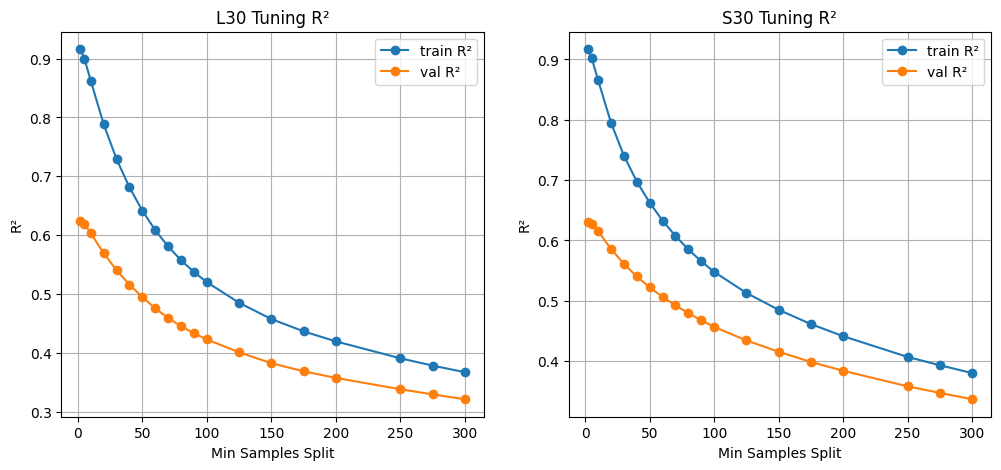

In [12]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    # for set_type, group_data in mission_data[mission_data['set_type']=='val'].groupby('set_type'):
    for set_type, group_data in mission_data.groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')
    ax.grid(True)

In [15]:
del tuning_results_df

## Number of estimators `n_estimators`

In [16]:
hp_name = 'n_estimators'
hp_values = list(range(10, 101, 10)) + list(range(125, 201, 25)) + list(range(250, 501, 50)) + list(range(600, 1001, 100))

hyperparameters = {
    hp_name: hp_values,
}


In [17]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [18]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [19]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(**{hp: value, 'random_state': seed})

        cv_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values,
                y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(
                y_true=y_val.values,
                y_pred=list(y_val_pred)
            )

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('train')
            tuning_results['mission'].append('l30')


            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('val')
            tuning_results['mission'].append('l30')

del hlsl30_insitu

In [20]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [21]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [22]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(**{hp: value, 'random_state': seed})

        cv_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values,
                y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(
                y_true=y_val.values,
                y_pred=list(y_val_pred)
            )

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('train')
            tuning_results['mission'].append('s30')


            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results['hyperparameter'].append(hp)
            tuning_results['hypervalue'].append(value)
            tuning_results['set_type'].append('val')
            tuning_results['mission'].append('s30')
del hlss30_insitu

In [23]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

In [7]:
tuning_results_df = pd.read_csv(f'n_estimators_results.csv')

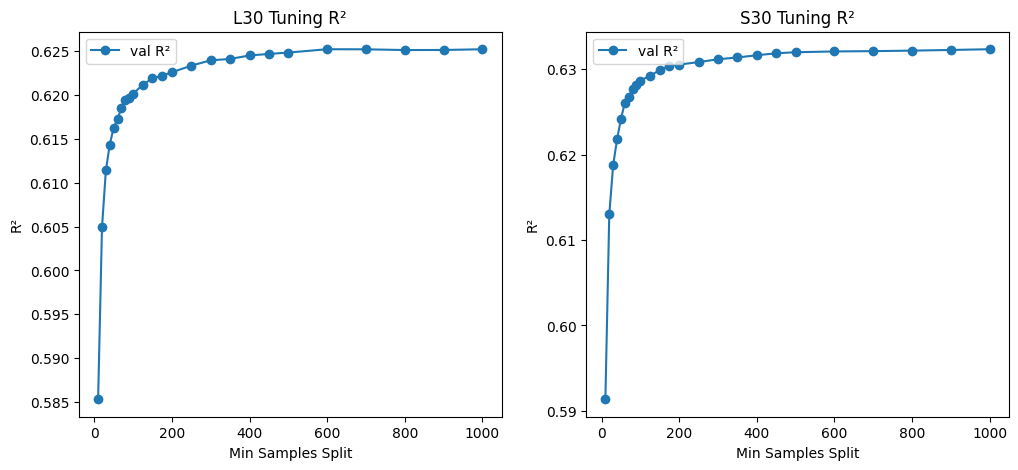

In [9]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    for set_type, group_data in mission_data[mission_data['set_type']=='val'].groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')

In [26]:
l30_tuning_results = tuning_results_df[tuning_results_df['mission']=='l30']
s30_tuning_results = tuning_results_df[tuning_results_df['mission']=='s30']
mean_r2_l30 = l30_tuning_results[l30_tuning_results['set_type']=='val'].groupby('hypervalue')['R2'].mean().reset_index()
mean_r2_s30 = s30_tuning_results[s30_tuning_results['set_type']=='val'].groupby('hypervalue')['R2'].mean().reset_index()

In [27]:
mean_r2_l30['delta_R2'] = mean_r2_l30['R2'] - mean_r2_l30['R2'].shift()
mean_r2_s30['delta_R2'] = mean_r2_s30['R2'] - mean_r2_s30['R2'].shift()

In [28]:
mean_r2_s30

,hypervalue,R2,delta_R2
0,10,0.591372,NaN
1,20,0.612990,0.021618
2,30,0.618758,0.005768
3,40,0.621762,0.003004
4,50,0.624163,0.002401
5,60,0.626019,0.001856
6,70,0.626721,0.000702
7,80,0.627666,0.000945
8,90,0.628179,0.000514
9,100,0.628650,0.000470


In [29]:
# select the hyperparameter value where delta_R2 first becomes less than 0.0005 for more than 2 consecutive values
def select_optimal_hyperparameter(mean_r2):
    count = 0
    for i in range(1, len(mean_r2)):
        if mean_r2.loc[i, 'delta_R2'] < 0.0005:
            count += 1
            if count >= 2:
                return mean_r2.loc[i - 1, 'hypervalue']
        else:
            count = 0
    return mean_r2.loc[len(mean_r2) - 1, 'hypervalue']

optimal_hyper_l30 = select_optimal_hyperparameter(mean_r2_l30)
optimal_hyper_s30 = select_optimal_hyperparameter(mean_r2_s30)

print(f'Optimal {hp_name} for L30: {optimal_hyper_l30}')
print(f'Optimal {hp_name} for S30: {optimal_hyper_s30}')


Optimal n_estimators for L30: 90
Optimal n_estimators for S30: 200


In [30]:
del tuning_results_df

## Max Samples `max_samples`

In [31]:
hp_name = 'max_samples'
hp_values = np.arange(.1, 1.1, .1)

hyperparameters = {
    hp_name: hp_values,
}


In [32]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [33]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [34]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("l30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("l30")

del hlsl30_insitu

In [35]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [36]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [37]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("s30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("s30")
del hlss30_insitu

In [38]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

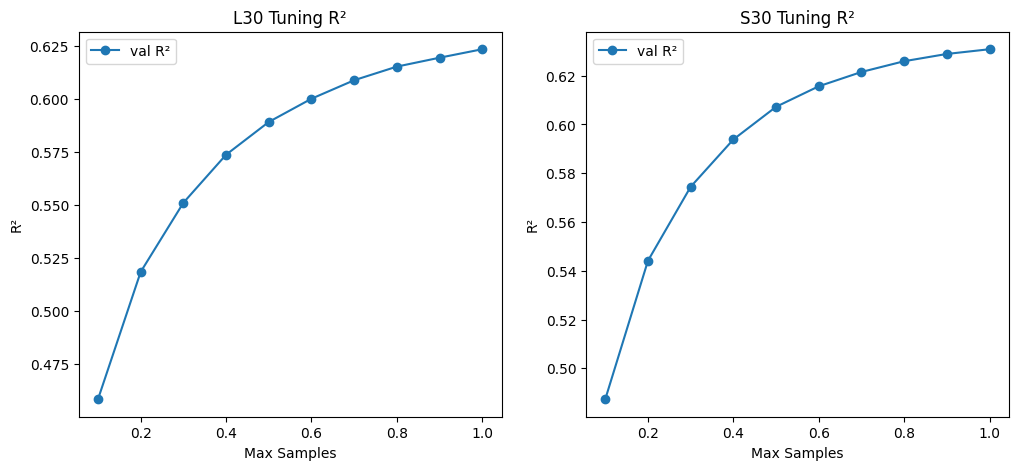

In [39]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    for set_type, group_data in mission_data[mission_data['set_type']=='val'].groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')

In [40]:
del tuning_results_df

Based on the tuning results for Max Samples tuning, the best value is `1.0` which is the default argument. Equivalent to `None`

Based on the tuning results for Min Samples Split tuning, the best value is `2` which is the default argument.

## Min Samples Leaf `min_samples_leaf`

In [41]:
hp_name = 'min_samples_leaf'
hp_values = [1] + list(range(10, 101, 10)) + list(range(125, 201, 25)) + list(range(250, 301, 25))

hyperparameters = {
    hp_name: hp_values,
}


In [42]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [43]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [44]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("l30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("l30")

del hlsl30_insitu

In [45]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [46]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [47]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("s30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("s30")
del hlss30_insitu

In [48]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

In [49]:
tuning_results_df = pd.read_csv(f'{hp_name}_results.csv')

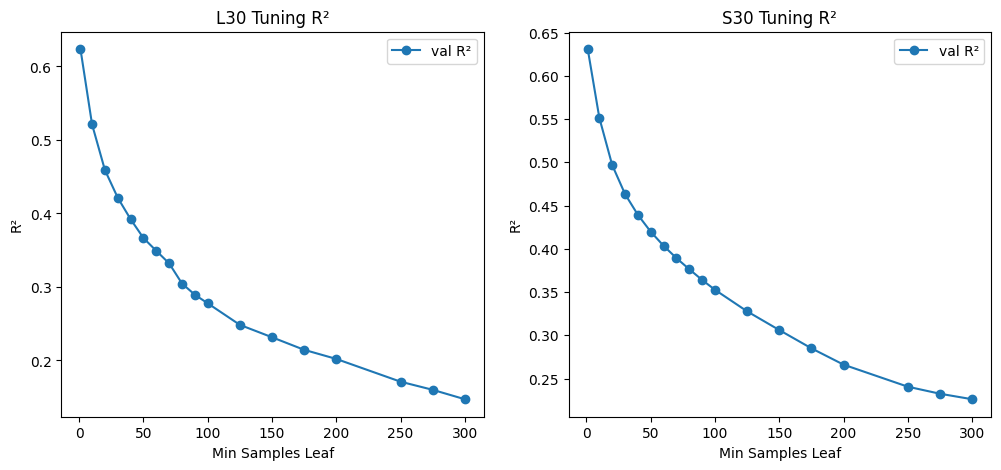

In [50]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    for set_type, group_data in mission_data[mission_data['set_type']=='val'].groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')

In [51]:
del tuning_results_df

Based on the tuning results for Min Samples Leaf, the best value is `1` which is the default argument.

## Max Features `max_features`

In [52]:
hp_name = 'max_features'
hp_values = np.arange(.1, 1.1, .1)

hyperparameters = {
    hp_name: hp_values,
}


In [53]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [54]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [55]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("l30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("l30")

del hlsl30_insitu

In [56]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [57]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [58]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("s30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("s30")
del hlss30_insitu

In [59]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

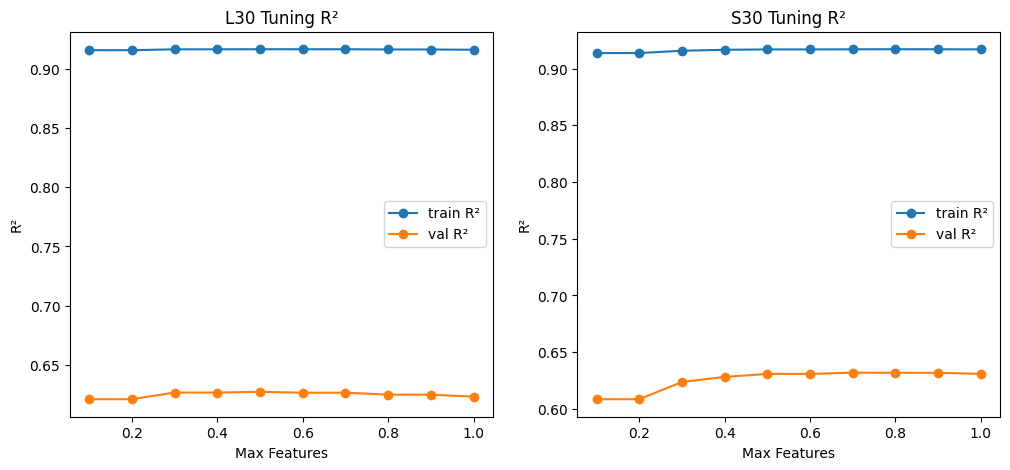

In [60]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    for set_type, group_data in mission_data.groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')

In [61]:
del tuning_results_df

## Max Depth `max_depth`

In [62]:
hp_name = 'max_samples'
hp_values = np.arange(.1, 1.1, .1)

hyperparameters = {
    hp_name: hp_values,
}


In [63]:
# define dictionary for tuning results
tuning_results = {metric: [] for metric in list_metrics}
tuning_results['hyperparameter'] = []
tuning_results['hypervalue'] = []
tuning_results['mission'] = []
tuning_results['set_type'] = []

tuning_results_df = pd.DataFrame(tuning_results)

### HLS Landsat

In [64]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter l30 data and select features + target
hlsl30_insitu = hls_insitu[hls_insitu['mission']=='l30'][
    [
        "Date",
        "StationID",
    ] + hlsl30_features + [hlsl30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlsl30_insitu.dropna(
    subset=hlsl30_features + [hlsl30_target],
    inplace=True,
    # how="all"
)
# shuffle l30 data
hlsl30_insitu = hlsl30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [65]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlsl30_insitu):
            X_train = hlsl30_insitu.iloc[train_index][hlsl30_features]
            y_train = hlsl30_insitu.iloc[train_index][hlsl30_target]

            X_val = hlsl30_insitu.iloc[val_index][hlsl30_features]
            y_val = hlsl30_insitu.iloc[val_index][hlsl30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("l30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("l30")

del hlsl30_insitu

In [66]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

del tuning_results_df

### HLS Sentinel-2

In [67]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

# filter s30 data and select features + target
hlss30_insitu = hls_insitu[hls_insitu['mission']=='s30'][
    [
        "Date",
        "StationID",
    ] + hlss30_features + [hlss30_target]
].copy()

# remove hls_insitu from memory
del hls_insitu

hlss30_insitu.dropna(
    subset=hlss30_features + [hlss30_target],
    inplace=True,
    # how="all"
)
# shuffle s30 data
hlss30_insitu = hlss30_insitu.sample(frac=1, random_state=seed).reset_index(drop=True)

In [68]:
for hp, hp_space in hyperparameters.items():
    for value in hp_space:
        model = RandomForestRegressor(
            **{hp: value, "random_state": seed, "n_estimators": 250}
        )

        cv_splitter = RepeatedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=seed
        )

        # cv_train_results = {metric: [] for metric in list_metrics}
        # cv_train_results['hyperparameter'] = []
        # cv_train_results['hypervalue'] = []
        # cv_train_results['set_type'] = []
        # cv_train_results['mission'] = []

        # cv_val_results = {metric: [] for metric in list_metrics}
        # cv_val_results['hyperparameter'] = []
        # cv_val_results['hypervalue'] = []
        # cv_val_results['set_type'] = []
        # cv_val_results['mission'] = []

        for train_index, val_index in cv_splitter.split(hlss30_insitu):
            X_train = hlss30_insitu.iloc[train_index][hlss30_features]
            y_train = hlss30_insitu.iloc[train_index][hlss30_target]

            X_val = hlss30_insitu.iloc[val_index][hlss30_features]
            y_val = hlss30_insitu.iloc[val_index][hlss30_target]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            train_metrics = RegressionMetric(
                y_true=y_train.values, y_pred=list(y_train_pred)
            )

            val_metrics = RegressionMetric(y_true=y_val.values, y_pred=list(y_val_pred))

            train_metrics = train_metrics.get_metrics_by_list_names(list_metrics)
            val_metrics = val_metrics.get_metrics_by_list_names(list_metrics)

            # calculate metrics
            for metric in list_metrics:
                tuning_results[metric].append(train_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("train")
            tuning_results["mission"].append("s30")

            for metric in list_metrics:
                tuning_results[metric].append(val_metrics[metric])

            tuning_results["hyperparameter"].append(hp)
            tuning_results["hypervalue"].append(value)
            tuning_results["set_type"].append("val")
            tuning_results["mission"].append("s30")
del hlss30_insitu

In [69]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.to_csv(f'{hp_name}_results.csv', index=False)

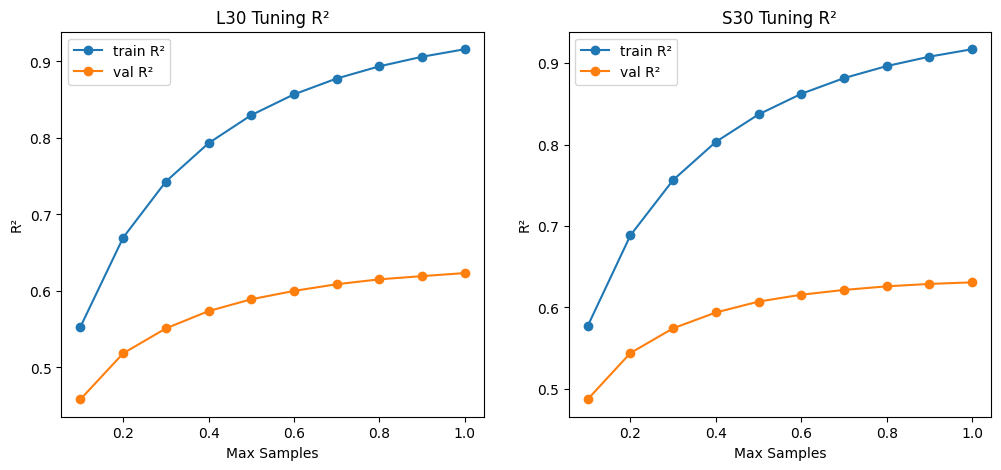

In [70]:
# plot the tuning results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, mission in enumerate(tuning_results_df['mission'].unique()):
    ax = axs[i]
    mission_data = tuning_results_df[tuning_results_df['mission'] == mission]
    for set_type, group_data in mission_data.groupby('set_type'):
        # plot boxplots of R2 for each hyperparameter value
        # grouped_r2 = group_data.groupby('hypervalue')['R2'].apply(list).reset_index()

        # ax.boxplot(
        #     grouped_r2['R2'],
        #     tick_labels=[round(hv, 1) for hv in grouped_r2['hypervalue']],
        #     # widths=0.05 if hp_name == 'max_features' else 1.0,
        #     patch_artist=True,
        # )

        # line plot of mean R2 for each hyperparameter value
        mean_r2 = group_data.groupby('hypervalue')['R2'].mean().reset_index()
        ax.plot(
            mean_r2['hypervalue'],
            mean_r2['R2'],
            marker='o',
            label=f'{set_type} R²'
        )

    ax.legend()
    ax.set_title(f'{mission.upper()} Tuning R²')
    ax.set_xlabel(hp_name.replace('_', ' ').title())
    ax.set_ylabel('R²')

In [71]:
del tuning_results_df